In [2]:
# Segmentation
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
# Plot
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np 
import cv2

# Encoder - Decoder
# Texture
# sys.path.insert(0, '/home/giang.nguyen/FashionStyle/FashionPlus/generation')

# from options.train_options import TrainOptions
# from data.data_loader import CreateDataLoader
# from models.models import create_model
# import util.util as util
# import pickle


# # Shape
# sys.path.insert(1, '/home/giang.nguyen/FashionStyle/FashionPlus/separate_vae')


# Utils
import os
import time
from tqdm import tqdm 
import random
###############################


```
# label index:  segment name
0            :  null
1            :  hat
2            :  hair
3            :  glasses
4            :  up(per clothing)
5            :  skirt
6            :  pants
7            :  dress
8            :  belt
9            :  r-shoe
10           :  l-shoe
11           :  face
12           :  r-leg
13           :  l-leg
14           :  r-arm
15           :  l-arm
16           :  bag
17           :  scarf
```

In [6]:
class Retrieval:
    classes = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear', \
               'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress', 'vest_dress', \
               'sling_dress', 'glasses', 'shoe', 'bag']
    mask_classes = ['up', 'up', 'up', 'up', 'up', 'up', 'pants', 'pants', 'skirt', 'dress', \
                    'dress', 'dress', 'dress', 'glasses', 'shoe', 'bag']
    seg_map = [4, 4, 4, 4, 4, 4, 6, 6, 5, 7, 7, 7, 7, 3, 9, 16]
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]
    # threshold = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3]
    threshold = {'short_sleeved_shirt': 0.5, 'long_sleeved_shirt': 0.5, 'short_sleeved_outwear': 0.5, 'long_sleeved_outwear': 0.4, \
               'vest': 0.5, 'sling': 0.5, 'shorts': 0.5, 'trousers': 0.5, 'skirt': 0.5, 'short_sleeved_dress': 0.5, 'long_sleeved_dress': 0.5, 'vest_dress': 0.5, \
               'sling_dress': 0.5, 'glasses': 0.2, 'shoe': 0.4, 'bag': 0.3}

    model_df2_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2.py'
    model_shoe_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb.py'
    model_df2_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/latest.pth'
    model_shoe_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/latest.pth'

    create_database = False

    mask_dest = 'datasets/humanparsing/train_mask'

    def __init__(self):
        # Load mmdet models
        self.model_shoe = init_detector(self.model_shoe_config, self.model_shoe_pth, device='cuda:0')
        self.model_df2 = init_detector(self.model_df2_config, self.model_df2_pth, device='cuda:0')

        # Load encoder

        # Load database
        if not self.create_database:
            # self.database = load()
            pass
        else:
            # self.database = create_database()
            pass
    
    def detect(self, image):
        file_name = image.split('/')[-1].replace('.jpg','.png')
        # print(file_name)
        tic = time.time()
        self.res_shoe = inference_detector(model=self.model_shoe, img=image)
        toc = time.time()
        self.res_df2  = inference_detector(model=self.model_df2, img=image)
        # print(self.res_shoe,'---', self.res_df2)   
        if len(np.array(self.res_shoe[0]).shape) > 1:
            tmp = np.random.rand(1,5)
            tmp[0,4] = 0.01
            self.res_shoe[0][0] = np.concatenate((self.res_shoe[0][0],tmp), axis = 0)
        if len(np.array(self.res_df2[0]).shape) > 1:
            tmp = np.random.rand(1,5)
            tmp[0,4] = 0.01
            self.res_df2[0][0] = np.concatenate((self.res_df2[0][0],tmp), axis = 0)

        self.res = np.concatenate((self.res_df2, self.res_shoe), axis=1)

    def draw_output(self, img, res, score=0.5):
        img = cv2.imread(img)
        res = self.res[0,:]
        # file_name = image.split('/')[-1]
        for i in range(len(res)):
            if len(res[i]) > 0 :
                for j in range(len(res[i])):
                    if res[i][j][4] > self.threshold[self.classes[i]]:
                        x1y1 = (res[i][j][0].astype(np.int32), res[i][j][1].astype(np.int32))
                        x4y4 = (res[i][j][2].astype(np.int32), res[i][j][3].astype(np.int32))

                        img = cv2.rectangle(img, x1y1, x4y4, self.colors[i], 2)
                        img = cv2.putText(img, '{} {:.4f}'.format(
                                        self.classes[i], res[i][j][4]),
                                        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, self.colors[i], 2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def create_database(self, image):
        file_name = image.split('/')[-1].replace('.jpg','.png')
        # self.masks = []
        self.mask = list()
        self.mask_items = dict()
        # self.mask_items = list()
        res = self.res[0,:]
        for i in range(len(res)):
            if len(res[i]) > 0 :
                for j in range(len(res[i])):
                    if res[i][j][4] > self.threshold[self.classes[i]]:
                        self.mask_items[self.mask_classes[i]] = 1*self.res[1,i][j]*self.seg_map[i]
                        # self.mask_items.append(1*self.res[1,i][j]*self.seg_map[i])
        self.mask = np.maximum.reduce([i for key, i in self.mask_items.items() if len(i) > 0])
        Image.fromarray(np.array(self.mask).astype(np.uint8)).save(f'{self.mask_dest}/{file_name}')
        # self.mask = np.maximum.reduce([i for i in self.mask_items if len(i) > 0])

    def load_database(self):
        pass

    def retrieaval(self, image):
        pass

    def plot_image(self, image):
        pass

demo = Retrieval()
print('Initialized')
    

Initialized


 11%|█         | 1906/17706 [10:59<1:31:06,  2.89it/s]dataset10k_9265.jpg



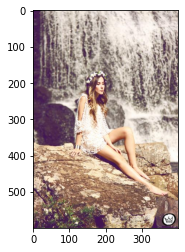

In [10]:
source = 'datasets/humanparsing/train_img'

######################
files = os.listdir(source)

for img in tqdm(files):
    demo.detect(f'{source}/{img}')

    try:
        demo.create_database(f'{source}/{img}')
    except:
        plt.figure()
        plt.imshow(demo.draw_output(f'{source}/{img}', demo.res, 0.4))
        print(img)
        break

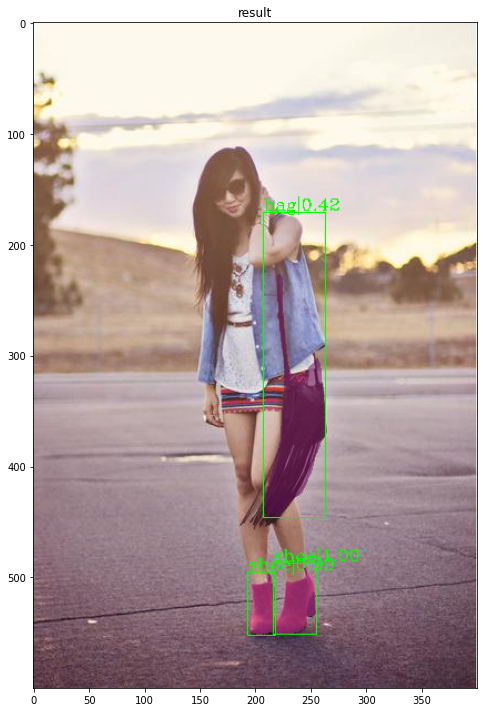

(3, 2, 5) 3
****
-----
(2, 5)
llll
(5,)
llll
(5,)
-----
(2, 5)
llll
(5,)
llll
(5,)
-----
(2, 5)
llll
(5,)
llll
(5,)
(3, 2, 600, 400) 4
****
-----
(2, 600, 400)
llll
(600, 400)
llll
(600, 400)
-----
(2, 600, 400)
llll
(600, 400)
llll
(600, 400)
-----
(2, 600, 400)
llll
(600, 400)
llll
(600, 400)


In [135]:
image = 'datasets/humanparsing/train_img/dataset10k_7017.jpg'
# image = 'datasets/humanparsing/train_img/2500_509.jpg'

model_df2_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2.py'
model_shoe_config = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb.py'
model_df2_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_df2/latest.pth'
model_shoe_pth = '/home/giang.nguyen/mmdetection/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x_sgb/latest.pth'


model_shoe = init_detector(model_shoe_config, model_shoe_pth, device='cuda:0')
model_df2 = init_detector(model_df2_config, model_df2_pth, device='cuda:0')

res_shoe = inference_detector(model=model_shoe, img=image)
res_df2  = inference_detector(model=model_df2, img=image)  

# np_res_shoe = np.array([np.array([np.expand_dims(np.array(j),axis=0) for j in i if len()]) for i in res_shoe])
# print(np_res_shoe.shape)
# print(np_res_shoe.shape)
# print(np.array(res_shoe))
# res = np.concatenate((res_df2, res_shoe), axis=1)

show_result_pyplot(model_shoe, image, res_shoe)
# res_shoe = [[j[0] for j in i] for i in res_shoe]

# show_result_pyplot(model_df2, image, res_df2)
# plt.imshow(Image.open(test_image))
# print(len(res_shoe[1]))
for i in res_shoe:
    tmp = np.array(i)
    print(tmp.shape, len(tmp.shape))
    print('****')
    for j in i:
        print('-----')
        tmp = np.array(j)
        # tmp = np.expand_dims(tmp, axis=0)
        print(tmp.shape)
        # j = tmp
        for k in j:
            print('llll')
            tmp = np.array(k)
            # tmp = np.expand_dims(tmp, axis=0)

            print(tmp.shape)
            # k = tmp

tmp1 = res_shoe
# tmp = np.array(np.array[i] for i in np.array(res_shoe))
# print(t)
# demo.detect(test_image)
# img = demo.draw_output(test_image, demo.res[0,:])

In [201]:
print(res_shoe[0][0] )
tmp = np.random.rand(1,5)
tmp[0,4] = 0.01
print(tmp)
res_shoe[0][0] = np.concatenate((res_shoe[0][0],tmp), axis = 0)

[[1.64016006e+02 1.39439819e+02 1.93734558e+02 1.62938354e+02
  2.35852882e-01]
 [1.77033218e+02 2.04394379e+02 1.96745224e+02 2.49890381e+02
  5.51324040e-02]
 [8.33194912e-01 1.73364654e-01 3.91060608e-01 1.82236088e-01
  1.00000000e-02]]
[[0.42515587 0.20794166 0.56770033 0.03131329 0.01      ]]


In [198]:
np.array(res_shoe)

array([[array([[1.64016006e+02, 1.39439819e+02, 1.93734558e+02, 1.62938354e+02,
        2.35852882e-01],
       [1.77033218e+02, 2.04394379e+02, 1.96745224e+02, 2.49890381e+02,
        5.51324040e-02],
       [8.33194912e-01, 1.73364654e-01, 3.91060608e-01, 1.82236088e-01,
        1.00000000e-02]]),
        array([[216.72366   , 487.46997   , 255.46541   , 551.9386    ,
          0.9965564 ],
       [193.75977   , 495.92618   , 218.87666   , 552.10956   ,
          0.99428517]], dtype=float32),
        array([[2.0750113e+02, 1.7102507e+02, 2.6311044e+02, 4.4665216e+02,
        4.2365247e-01],
       [2.0931250e+02, 3.0044800e+02, 2.6377377e+02, 4.4343530e+02,
        6.0868714e-02]], dtype=float32)],
       [list([array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,

In [171]:
tmp = np.array(shoe_bbox)
bboxes = np.vstack(shoe_bbox)
labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)
    for i, bbox in enumerate(shoe_bbox)
]
print(bboxes.shape)
print(labels)

(6, 5)
[array([0, 0], dtype=int32), array([1, 1], dtype=int32), array([2, 2], dtype=int32)]


In [94]:
for i in tmp1:
    # print(len(i))
    print(np.squeeze(np.array(i)).shape)
    for j in i:
        print(np.array(j).shape)
        print(len(j))
    print('----')

(3, 2, 5)
(2, 5)
2
(2, 5)
2
(2, 5)
2
----
(3, 2, 600, 400)
(2, 600, 400)
2
(2, 600, 400)
2
(2, 600, 400)
2
----


In [82]:
print(np.array(tmp1[0]), np.array(tmp1[0]).shape)
print('----')
print(tmp1[0])
print('----')
print(tmp2[0])

[[[1.6401601e+02 1.3943982e+02 1.9373456e+02 1.6293835e+02 2.3585288e-01]
  [1.7703322e+02 2.0439438e+02 1.9674522e+02 2.4989038e+02 5.5132404e-02]]

 [[2.1672366e+02 4.8746997e+02 2.5546541e+02 5.5193860e+02 9.9655640e-01]
  [1.9375977e+02 4.9592618e+02 2.1887666e+02 5.5210956e+02 9.9428517e-01]]

 [[2.0750113e+02 1.7102507e+02 2.6311044e+02 4.4665216e+02 4.2365247e-01]
  [2.0931250e+02 3.0044800e+02 2.6377377e+02 4.4343530e+02 6.0868714e-02]]] (3, 2, 5)
----
[array([[1.6401601e+02, 1.3943982e+02, 1.9373456e+02, 1.6293835e+02,
        2.3585288e-01],
       [1.7703322e+02, 2.0439438e+02, 1.9674522e+02, 2.4989038e+02,
        5.5132404e-02]], dtype=float32), array([[216.72366   , 487.46997   , 255.46541   , 551.9386    ,
          0.9965564 ],
       [193.75977   , 495.92618   , 218.87666   , 552.10956   ,
          0.99428517]], dtype=float32), array([[2.0750113e+02, 1.7102507e+02, 2.6311044e+02, 4.4665216e+02,
        4.2365247e-01],
       [2.0931250e+02, 3.0044800e+02, 2.6377377e+0

In [80]:
tmp3 = np.array([np.array(i) for i in tmp2])
# print(np.array(tmp2[0]), np.array(tmp2[0]).shape)
print(tmp3[0], tmp3[0].shape, type(tmp3))
print(type(tmp3[0]), tmp3[0].shape)
print(type(np.array(tmp1[0])),np.array(tmp1[0]).shape)#, tmp1[0].shape)
print(tmp2[0], type(tmp2[0]))
print(tmp1[0], type(tmp1[0]))


[array([[2.5920981e+02, 3.1473798e+02, 2.9039062e+02, 3.6293121e+02,
        8.3580978e-02]], dtype=float32)
 array([[1.6614445e+02, 5.0759601e+02, 2.0979529e+02, 5.6861005e+02,
        9.9098980e-01],
       [1.5583408e+02, 4.8120541e+02, 1.9200406e+02, 5.4139508e+02,
        9.5004362e-01],
       [2.5922565e+02, 3.1377911e+02, 2.9075729e+02, 3.6304065e+02,
        1.2871300e-01]], dtype=float32)
 array([[2.4203580e+02, 1.5966631e+02, 2.8864786e+02, 3.6467145e+02,
        4.9973843e-01],
       [2.5920981e+02, 3.1473798e+02, 2.9039062e+02, 3.6293121e+02,
        4.8653048e-01],
       [2.5336382e+02, 2.3788095e+02, 2.9138077e+02, 3.6394986e+02,
        2.6796973e-01]], dtype=float32)] (3,) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (3,)
<class 'numpy.ndarray'> (3, 2, 5)
[array([[2.5920981e+02, 3.1473798e+02, 2.9039062e+02, 3.6293121e+02,
        8.3580978e-02]], dtype=float32), array([[1.6614445e+02, 5.0759601e+02, 2.0979529e+02, 5.6861005e+02,
        9.9098980e-01],
       [1.

In [127]:
tmp1 = [np.expand_dims([np.expand_dims([np.expand_dims(np.array(k), axis=0) for k in i]),axis=0) for i in j]),axis=0) for j in tmp1]

SyntaxError: invalid syntax (<ipython-input-127-be8d06b6efd3>, line 1)

In [126]:
np.array(tmp1)

ValueError: could not broadcast input array from shape (5) into shape (1)

In [133]:
a = [np.zeros((224,224,3)), np.zeros((224,224,3)), np.zeros((224,2,2))]

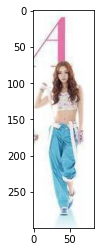

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
image = 'datasets/humanparsing/train_img/Multi_340.jpg'
plt.imshow(Image.open(image))